In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import zipfile
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM
from tensorflow.keras.models import load_model

In [3]:
zip_file = zipfile.ZipFile("/content/drive/MyDrive/NLP_Vol1/UPDATED_NLP_COURSE.zip","r")
zip_file.extractall()
zip_file.close()

In [4]:
with open("/content/UPDATED_NLP_COURSE/06-Deep-Learning/train_qa.txt", "rb") as f:
    train_data = pickle.load(f)

with open("/content/UPDATED_NLP_COURSE/06-Deep-Learning/test_qa.txt", "rb") as f:
    test_data = pickle.load(f)

In [5]:
type(train_data),type(test_data)

(list, list)

In [6]:
len(train_data),len(test_data)

(10000, 1000)

In [7]:
len(train_data[0])

3

In [8]:
print(train_data[0][0]),print(train_data[0][1]),print(train_data[0][2])

['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.']
['Is', 'Sandra', 'in', 'the', 'hallway', '?']
no


(None, None, None)

In [9]:
" ".join(train_data[0][0])," ".join(train_data[0][1])

('Mary moved to the bathroom . Sandra journeyed to the bedroom .',
 'Is Sandra in the hallway ?')

In [10]:
all_data = test_data + train_data
len(all_data)

11000

In [11]:
print(set(train_data[0][0]).union()),print(set(train_data[0][0]))

{'bathroom', 'to', 'Sandra', 'moved', 'journeyed', 'the', '.', 'Mary', 'bedroom'}
{'bathroom', 'to', 'Sandra', 'moved', 'journeyed', 'the', '.', 'Mary', 'bedroom'}


(None, None)

In [12]:
vocab = set()

for story,question,answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
vocab.add("no")
vocab.add("yes")

In [13]:
print(vocab)

{'to', 'yes', 'hallway', 'down', 'milk', 'Daniel', 'there', 'got', 'in', 'grabbed', 'office', '.', 'Mary', 'Sandra', 'moved', 'kitchen', 'John', 'went', 'put', 'bedroom', 'left', 'Is', 'up', 'the', 'discarded', 'back', 'no', 'took', 'bathroom', '?', 'picked', 'travelled', 'journeyed', 'garden', 'apple', 'dropped', 'football'}


In [14]:
vocab_len = len(vocab) + 1
vocab_len

38

In [15]:
# Longest Story
all_story_len = [len(data[0]) for data in all_data]
all_story_len[:4]

[12, 23, 35, 47]

In [16]:
max_story_len = max(all_story_len)
max_story_len

156

In [17]:
# Longest Question
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

In [18]:
vocab_len, max_story_len,max_question_len

(38, 156, 6)

In [19]:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab)

In [20]:
print(tokenizer.word_index)

{'to': 1, 'yes': 2, 'hallway': 3, 'down': 4, 'milk': 5, 'daniel': 6, 'there': 7, 'got': 8, 'in': 9, 'grabbed': 10, 'office': 11, '.': 12, 'mary': 13, 'sandra': 14, 'moved': 15, 'kitchen': 16, 'john': 17, 'went': 18, 'put': 19, 'bedroom': 20, 'left': 21, 'is': 22, 'up': 23, 'the': 24, 'discarded': 25, 'back': 26, 'no': 27, 'took': 28, 'bathroom': 29, '?': 30, 'picked': 31, 'travelled': 32, 'journeyed': 33, 'garden': 34, 'apple': 35, 'dropped': 36, 'football': 37}


In [21]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answers.append(answer)

In [22]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)
print(train_story_text[0],"\n",train_story_seq[0])

['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.'] 
 [13, 15, 1, 24, 29, 12, 14, 33, 1, 24, 20, 12]


In [23]:
len(train_story_text),len(train_story_seq)

(10000, 10000)

In [24]:
def vectorize_stories(data, word_index = tokenizer.word_index,max_story_len = max_story_len,max_question_len = max_question_len):

    # Stories
    X = []
    # Questions
    Xq = []
    # Target
    Y = []

    for story,question,answer in data:
        x =  [word_index[word.lower()] for word in story]
        xq =  [word_index[word.lower()] for word in question]
         
        y = np.zeros(len(word_index)+1)
        y[word_index[answer]] = 1

        X.append(x)
        Xq.append(xq)
        Y.append(y)

    return (pad_sequences(X, maxlen = max_story_len),pad_sequences(Xq, maxlen = max_question_len),np.array(Y))

In [25]:
inputs_train,queries_train,answers_train = vectorize_stories(train_data)
inputs_test,queries_test,answers_test = vectorize_stories(test_data)

In [26]:
tokenizer.word_index["yes"],tokenizer.word_index["no"]

(2, 27)

In [27]:
sum(answers_train)

array([   0.,    0., 5012.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       4988.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

---

In [28]:
len(vocab),vocab_len, max_story_len,max_question_len

(37, 38, 156, 6)

In [29]:
# Placeholder shape = (max_story_len, batch_size)
input_sequences = Input((max_story_len,))
question = Input((max_question_len,))
input_sequences,question

(<KerasTensor: shape=(None, 156) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'input_2')>)

In [30]:
# Vocab_len
vocab_size = len(vocab) + 1

In [31]:
# Input Encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_size, output_dim=64))
input_encoder_m.add(Dropout(rate = 0.3))
input_encoder_m.summary()

# OUTPUT
# (samples, story_maxlen, embedding_dim)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          2432      
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
Total params: 2,432
Trainable params: 2,432
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Input Encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(rate = 0.3))
input_encoder_c.summary()

# OUTPUT
# output: (samples, story_maxlen, query_maxlen)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 6)           228       
                                                                 
 dropout_1 (Dropout)         (None, None, 6)           0         
                                                                 
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Question Encoder 
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_size, output_dim=64,input_length= max_question_len))
question_encoder.add(Dropout(rate = 0.3))
question_encoder.summary()

# OUTPUT
# output: (samples, query_maxlen, embedding_dim)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 6, 64)             2432      
                                                                 
 dropout_2 (Dropout)         (None, 6, 64)             0         
                                                                 
Total params: 2,432
Trainable params: 2,432
Non-trainable params: 0
_________________________________________________________________


In [34]:
inputs_train[0].shape,queries_train[0].shape,answers_train[0].shape

((156,), (6,), (38,))

In [35]:
input_encoder_m(inputs_train[0]).shape,input_encoder_c(queries_train[0]).shape,question_encoder(answers_train[0]).shape

(TensorShape([156, 64]), TensorShape([6, 6]), TensorShape([38, 64]))

In [36]:
input_sequences,question

(<KerasTensor: shape=(None, 156) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'input_2')>)

In [37]:
# Encoded --- > Encoder(Input)
input_encoded_m = input_encoder_m(input_sequences)
input_encoded_c = input_encoder_c(input_sequences)
question_encoded = question_encoder(question)

In [38]:
input_encoded_m,input_encoded_c,question_encoded

(<KerasTensor: shape=(None, 156, 64) dtype=float32 (created by layer 'sequential')>,
 <KerasTensor: shape=(None, 156, 6) dtype=float32 (created by layer 'sequential_1')>,
 <KerasTensor: shape=(None, 6, 64) dtype=float32 (created by layer 'sequential_2')>)

In [39]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot( [input_encoded_m,question_encoded], axes = (2,2)) 
match 

<KerasTensor: shape=(None, 156, 6) dtype=float32 (created by layer 'dot')>

In [40]:
match = Activation("softmax")(match)
match

<KerasTensor: shape=(None, 156, 6) dtype=float32 (created by layer 'activation')>

In [41]:
# add the match matrix with the second input vector sequence
response = add([match,input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response 

<KerasTensor: shape=(None, 156, 6) dtype=float32 (created by layer 'add')>

In [42]:
response = Permute((2,1))(response)  # (samples, query_maxlen, story_maxlen)
response

<KerasTensor: shape=(None, 6, 156) dtype=float32 (created by layer 'permute')>

In [43]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response,question_encoded])
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [44]:
answer = LSTM(32)(answer)

answer = Dropout(rate = 0.5)(answer)
answer = Dense(vocab_size)(answer) # (samples, vocab_size)

In [45]:
answer = Activation("softmax")(answer)
answer

<KerasTensor: shape=(None, 38) dtype=float32 (created by layer 'activation_1')>

In [46]:
model = Model([input_sequences,question],answer)
model.compile(optimizer = "rmsprop",loss = "categorical_crossentropy",metrics = ["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [47]:
history = model.fit([inputs_train,queries_train],answers_train, batch_size = 32,epochs = 120,
                    validation_data = ([inputs_test,queries_test],answers_test))

Epoch 1/120
313/313 [==============================] - 19s 35ms/step - loss: 0.9310 - accuracy: 0.4953 - val_loss: 0.6947 - val_accuracy: 0.4970
Epoch 2/120
313/313 [==============================] - 9s 29ms/step - loss: 0.7035 - accuracy: 0.4971 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 3/120
313/313 [==============================] - 5s 17ms/step - loss: 0.6966 - accuracy: 0.4938 - val_loss: 0.6961 - val_accuracy: 0.4970
Epoch 4/120
313/313 [==============================] - 5s 17ms/step - loss: 0.6948 - accuracy: 0.4983 - val_loss: 0.6967 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 5s 17ms/step - loss: 0.6950 - accuracy: 0.4991 - val_loss: 0.6936 - val_accuracy: 0.4970
Epoch 6/120
313/313 [==============================] - 5s 17ms/step - loss: 0.6949 - accuracy: 0.4943 - val_loss: 0.6935 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 6s 18ms/step - loss: 0.6946 - accuracy: 0.4961 - val_loss: 0.6932 - val_accuracy

In [70]:
model.save("test_chat_bot.h5")
model.save_weights("test_chat_bot_weights.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


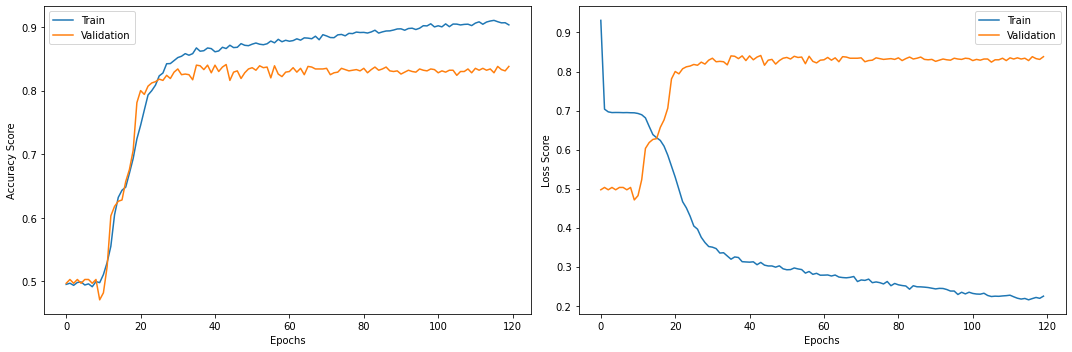

In [49]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend(loc = "best")

plt.subplot(1,2,2)
plt.plot(history.history["loss"],label = "Train")
plt.plot(history.history["val_accuracy"],label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss Score")
plt.legend(loc = "best")

plt.tight_layout()
plt.show()

In [71]:
new_model = load_model("/content/test_chat_bot.h5")
#new_model.summary()
new_model.load_weights("/content/test_chat_bot_weights.h5")

In [72]:
new_model.evaluate([inputs_test,queries_test],answers_test)

32/32 [==============================] - 1s 5ms/step - loss: 0.4749 - accuracy: 0.8380


[0.47492218017578125, 0.8379999995231628]

In [52]:
model.evaluate([inputs_test,queries_test],answers_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.4749 - accuracy: 0.8380


[0.47492218017578125, 0.8379999995231628]

In [53]:
pred_results = model.predict([inputs_test,queries_test])

In [54]:
pred_results.shape

(1000, 38)

In [76]:
i = 2
print("Story : ", " ".join(test_data[i][0]))
print()     
print("Query : ", " ".join(test_data[i][1]))
print()
print("True Test Answer from data is : ","".join(test_data[i][2]))
print()

val_max = np.argmax(pred_results[i])

for key,val in tokenizer.word_index.items():

    if val == val_max:
        k = key

print("\nPredicted answer is : ",k,"\nProbability of certainty was : ",pred_results[i][val_max])

Story :  Mary got the milk there . John moved to the bedroom . Mary discarded the milk . John went to the garden . Daniel moved to the bedroom . Daniel went to the garden .

Query :  Is John in the garden ?

True Test Answer from data is :  yes


Predicted answer is :  yes 
Probability of certainty was :  0.7453634


----

In [57]:
print(vocab)

{'to', 'yes', 'hallway', 'down', 'milk', 'Daniel', 'there', 'got', 'in', 'grabbed', 'office', '.', 'Mary', 'Sandra', 'moved', 'kitchen', 'John', 'went', 'put', 'bedroom', 'left', 'Is', 'up', 'the', 'discarded', 'back', 'no', 'took', 'bathroom', '?', 'picked', 'travelled', 'journeyed', 'garden', 'apple', 'dropped', 'football'}


In [58]:
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [59]:
my_question = "Is the football in the garden ?"
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [60]:
mydata = [(my_story.split(),my_question.split(), "yes")]
mydata

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [61]:
my_story, my_ques, my_ans = vectorize_stories(mydata)

In [66]:
print("My Story : " , "John left the kitchen . Sandra dropped the football in the garden .")
print()
print("My Question : ", "Is the football in the garden ?")
print()
print("My Answer : ", "Yes")
print()

my_pred_results = model.predict(([ my_story, my_ques]))

my_val_max = np.argmax(my_pred_results[0])

for key,val in tokenizer.word_index.items():

    if val == my_val_max:
        k = key

print("\nPredicted answer is : ",k,"\nProbability of certainty was : ",my_pred_results[0][my_val_max])

My Story :  John left the kitchen . Sandra dropped the football in the garden .

My Question :  Is the football in the garden ?

My Answer :  Yes


Predicted answer is :  yes 
Probability of certainty was :  0.9417404
